In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram, welch
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller, pacf
from tqdm.notebook import tqdm
import math
from scipy.stats import entropy
from scipy import interpolate
import ptitprince as pt
import seaborn as sns
import pingouin
import EntropyHub as EH

In [281]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1: #catch the whole entry being NaN
            #catch nan, catch hitting middle of confidence slider, catch ending time
            #i.e. this condidtion is it taps on the middle of the confidence slider
            if len(rating[i]) > 1 and time[i][0] < 0.1 and time[i][-1] > 10:
                res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
                rating_windowed = rating[i][res_unchanged:len(rating[i])]
                time_windowed = time[i][res_unchanged:len(rating[i])]
                #replace trials with error in data logging with nan
                #for trials that has a very long reaction time (about 10 seconds), filter it away
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            #condition: no nan but tap on the slider (0.1s being the reaction time)
            elif len(rating[i]) > 1 and time[i][0] > 0.1 and time[i][-1] > 10:
                rating_windowed = rating[i] #don't window as it starts recording only when click the slider
                time_windowed = time[i]
                if time_windowed[0] < 10 and len(time_windowed) > 100:
                    rating_windowed_list.append(rating_windowed)
                    time_windowed_list.append(time_windowed)
                else:
                    rating_windowed_list.append([np.NaN])
                    time_windowed_list.append([np.NaN])
                    failed_index_list.append(i)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])


    
        
    return rating_windowed_list, time_windowed_list, failed_index_list


def downsample(rating, time):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),0.025)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def flatten(seq):
    l = []
    for elt in seq:
        t = type(elt)
        if t is tuple or t is list:
            for elt2 in flatten(elt):
                l.append(elt2)
        else:
            l.append(elt)
    return l

#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_square_list.append(np.sum(np.array(rating[i]) ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list

def power_spectrum_welch(rating):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            f, S = welch(rating[i], 40)
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list

#permutation entropy - complexity

def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

def permutation_entropy_func(rating, dx):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy = ordpy.permutation_entropy(rating[i], dx = dx)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

def sample_entropy_func(rating, dx):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy = nolds.sampen(rating[i], emb_dim = dx)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

def sample_entropy_func_tolerance(rating, dr):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            std = np.std(rating[i])
            entropy = nolds.sampen(rating[i], tolerance = dr*std)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

def sample_entropy_func_heatmap(rating, dx, dr):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            std = np.std(rating[i])
            entropy, A, B = EH.SampEn(rating[i], m = dx, r = dr*std)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

def sample_entropy_func_default(rating):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy = nolds.sampen(rating[i])
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list


def approx_entropy_func(rating, dx):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, Phi = EH.ApEn(rating[i], m=dx)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

def approx_entropy_func_heatmap(rating, dx, dr):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            std = np.std(rating[i])
            entropy, Phi = EH.ApEn(rating[i], m = dx, r=dr*std)
            entropy_list.append(entropy)
        else:
            entropy_list.append(np.NaN)
    return entropy_list



def multiscale_entropy_func(rating, dx):
    Mobj = EH.MSobject('SampEn', m = dx)
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            MSE, CI_MS = EH.MSEn(rating[i], Mobj)
            entropy_list.append(MSE)
        else:
            entropy_list.append(np.NaN)
    return entropy_list


def multiscale_entropy_func_heatmap(rating, dx, dr, scale):
    entropy_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            std = np.std(rating[i])
            Mobj = EH.MSobject('SampEn', m = dx, r = dr*std)
            MSE, CI_MS = EH.MSEn(rating[i], Mobj, Scales = scale)
            entropy_list.append(MSE)
        else:
            entropy_list.append(np.NaN)
    return entropy_list

#autocorrelation
def autocorrelation(rating, time):
    acorr_list = []
    time_lag_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN, np.NaN, np.NaN])
    for i in range(len(time)):
        if len(time[i]) > 1:
            time_lag = np.array(time[i]) - np.array(time[i][0])
            time_lag_list.append(time_lag)
        else:
            time_lag_list.append([np.NaN, np.NaN, np.NaN])
    return acorr_list, time_lag_list

#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list
    

    

In [368]:
#list all the data files and its path
onlyfiles = [f for f in listdir('../Data/data_file') if isfile(join('../Data/data_file', f))]
files = []
for i in range(len(onlyfiles)):
    path = '../Data/data_file/' + onlyfiles[i]
    files.append(path)
files
data = pd.read_pickle(files[2])
data


,PID,ratings,time,Prediction,Confidence
0,5cf4949170036500157cd383,"[[3.9564919407818815, 3.9564919407818815, 3.95...","[[2.0, 2.05, 2.0999999999999996, 2.14999999999...",2.993629,2.553103
1,61605e62983592f4112241a6,"[[0.09578400567323965, 0.09578400567323965, 0....","[[0.7, 0.75, 0.8, 0.8500000000000001, 0.900000...",0.478158,9.676871
2,5a9ea9fe1ade740001b92063,"[[5.438168051345614, 5.438168051345614, 5.4381...","[[1.1, 1.1500000000000001, 1.2000000000000002,...",5.372540,6.275510
3,600606925db9c892b3939202,"[[0.7623176866689707, 0.7604213459578191, 0.74...","[[1.5, 1.55, 1.6, 1.6500000000000001, 1.700000...",0.945233,7.556328
4,61718d5a91c07b60dcc57a8e,"[[4.342549218724408, 4.342549218724408, 4.3425...","[[2.1, 2.15, 2.1999999999999997, 2.24999999999...",NaN,8.397022
...,...,...,...,...,...
74,63e51e7aecab96d2000c7278,"[[4.77489515503544, 4.764061891568549, 4.75093...","[[1.5, 1.55, 1.6, 1.6500000000000001, 1.700000...",NaN,7.008555
75,6382b72aed06259fad6fb159,"[[3.19250009364667, 3.0144940278191084, 2.5106...","[[2.9, 2.9499999999999997, 2.9999999999999996,...",NaN,6.535818
76,594bbc60a2356e000171d35d,"[[0.9126570319379258, 0.9126570319379258, 0.91...","[[1.4, 1.45, 1.5, 1.55, 1.6, 1.650000000000000...",1.460296,9.893794
77,6154a4a9767d18966bbccd82,"[[2.0773316013328604, 2.0773316013328604, 2.07...","[[3.5, 3.55, 3.5999999999999996, 3.64999999999...",NaN,4.705870


In [392]:
rating_all = data['ratings']
time_all = data['time']

In [370]:
dx_list = [3,30,100]
entropy_list_all_dx = []
for dx in dx_list:
    entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        entropy_list = permutation_entropy_func(rating_all[i], dx)
        entropy_list_all.append(entropy_list)
    entropy_list_all_dx.append(entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

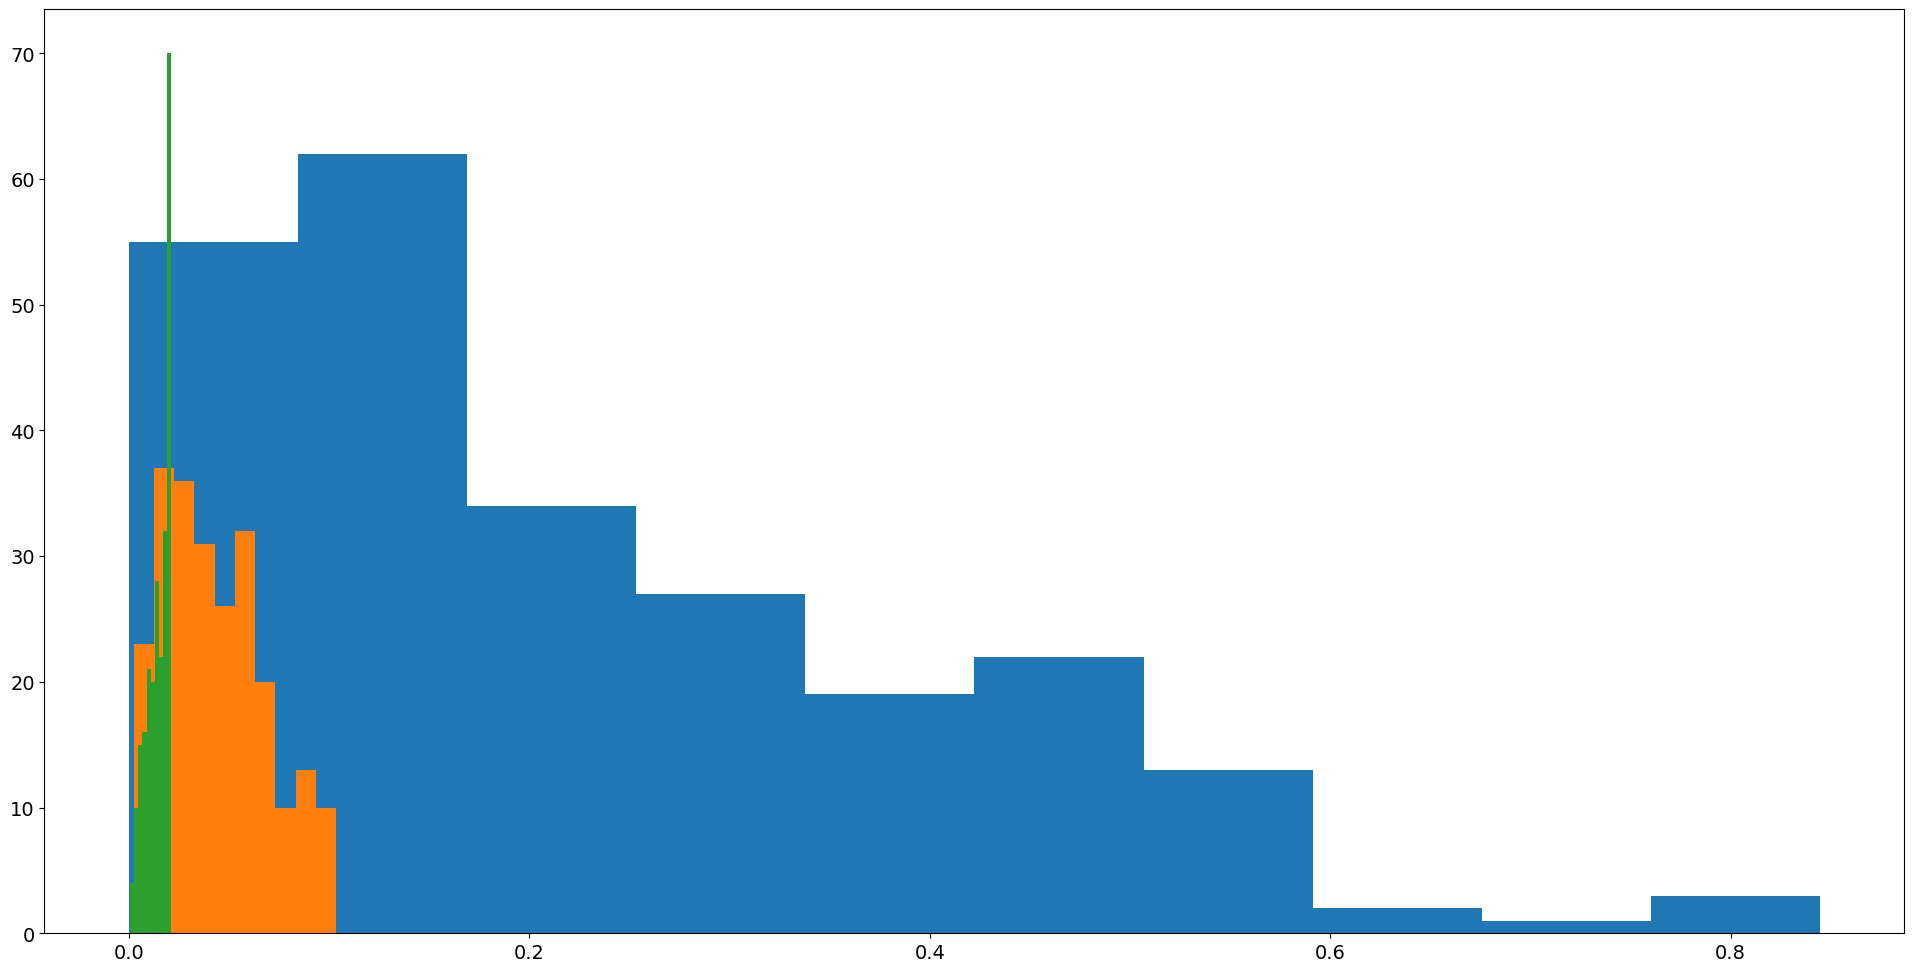

In [371]:
for i in range(len(dx_list)):
    plt.hist(flatten(entropy_list_all_dx[i]))

In [70]:
import nolds

In [78]:
nolds.sampen(rating_all[0][0])
ordpy.permutation_entropy(rating_all[0][0])

0.20409498024225753

In [112]:
sample_entropy_list_all = []
for i in tqdm(range(len(rating_all))):
    sample_entropy_list = sample_entropy_func_default(rating_all[i])
    sample_entropy_list_all.append(sample_entropy_list)

  0%|          | 0/79 [00:00<?, ?it/s]

In [121]:
np.argmax(flatten(sample_entropy_list_all))
sample_entropy_flatten = flatten(sample_entropy_list_all)
del sample_entropy_flatten[82]

(array([79.90304513, 25.89450537, 22.93513333, 12.57733118, 12.57733118,
         4.43905806,  3.69921505,  5.17890107,  3.69921505,  0.73984301,
         2.21952903,  0.        ,  0.73984301,  0.73984301,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.73984301,  0.        ,  0.        ,  0.73984301,
         0.73984301,  0.        ,  0.73984301,  0.        ,  0.73984301,
         0.        ,  0.73984301,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.73984301,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.73984301,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.73984301,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

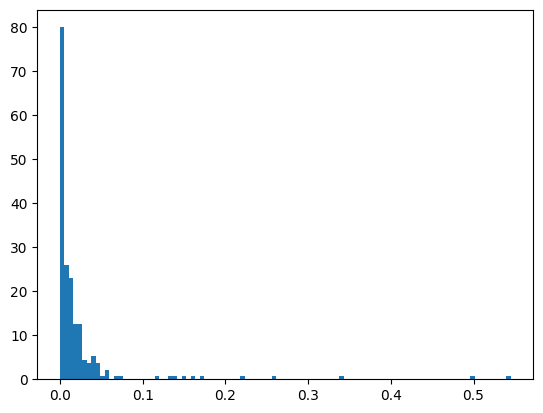

In [123]:
plt.hist(sample_entropy_flatten, bins = 100, density = True)

# Permutation Entropy

In [132]:
dx_list = [2,3,4,5,6,7,8,9,10]
permutation_entropy_list_all_dx = []
for dx in dx_list:
    permutation_entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        permutation_entropy_list = permutation_entropy_func(rating_all[i], dx)
        permutation_entropy_list_all.append(permutation_entropy_list)
    permutation_entropy_list_all_dx.append(permutation_entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

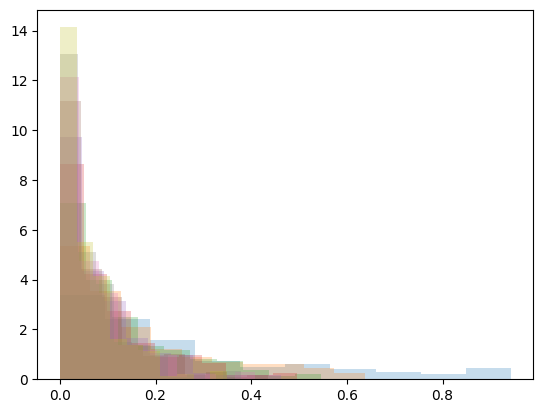

In [223]:
for i in range(len(permutation_entropy_list_all_dx)):
    plt.hist(flatten(permutation_entropy_list_all_dx[i]), density = True, alpha = 0.25)

# Sample Entropy

In [379]:
sample_entropy_list_all_default = []
for i in tqdm(range(len(rating_all))):
    sample_entropy_list = sample_entropy_func_default(rating_all[i])
    sample_entropy_list_all_default.append(sample_entropy_list)

  0%|          | 0/79 [00:00<?, ?it/s]

In [234]:
dx_list = [2,3,4,5,6,7,8,9,10]
sample_entropy_list_all_dx = []
for dx in dx_list:
    sample_entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        sample_entropy_list = sample_entropy_func(rating_all[i], dx)
        sample_entropy_list_all.append(sample_entropy_list)
    sample_entropy_list_all_dx.append(sample_entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

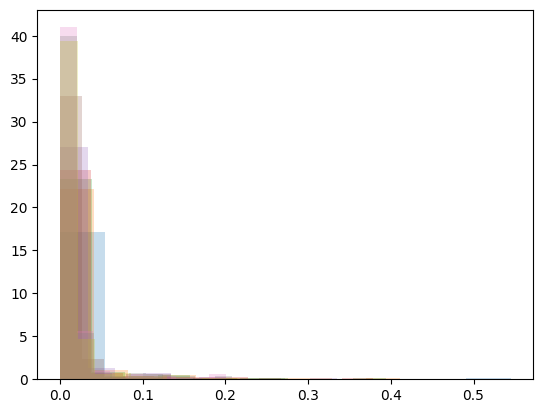

In [246]:
for i in range(len(sample_entropy_list_all_dx)):
    plt.hist(np.array(flatten(sample_entropy_list_all_dx[i]))[np.argwhere(np.array(flatten(sample_entropy_list_all_dx[i]))<1000)], density = True, alpha = 0.25)

In [319]:
dr_list = [0.1,0.2,0.3]
dx = 10
sample_entropy_list_all_dr = []
for dr in dr_list:
    sample_entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        sample_entropy_list = sample_entropy_func_heatmap(rating_all[i], dx, dr)
        sample_entropy_list_all.append(sample_entropy_list)
    sample_entropy_list_all_dr.append(sample_entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [320]:
np.save('SampEn_heatmap.npy', sample_entropy_list_all_dr)

c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [323]:
r_1 = sample_entropy_list_all_dr[0]
r_2 = sample_entropy_list_all_dr[1]
r_3 = sample_entropy_list_all_dr[2]

(array([27.42212581,  2.22341561,  0.24704618,  0.24704618,  0.        ,
         0.24704618,  0.12352309,  0.12352309,  0.        ,  0.12352309]),
 array([0.        , 0.03251266, 0.06502532, 0.09753798, 0.13005064,
        0.1625633 , 0.19507596, 0.22758862, 0.26010128, 0.29261394,
        0.3251266 ]),
 <BarContainer object of 10 artists>)

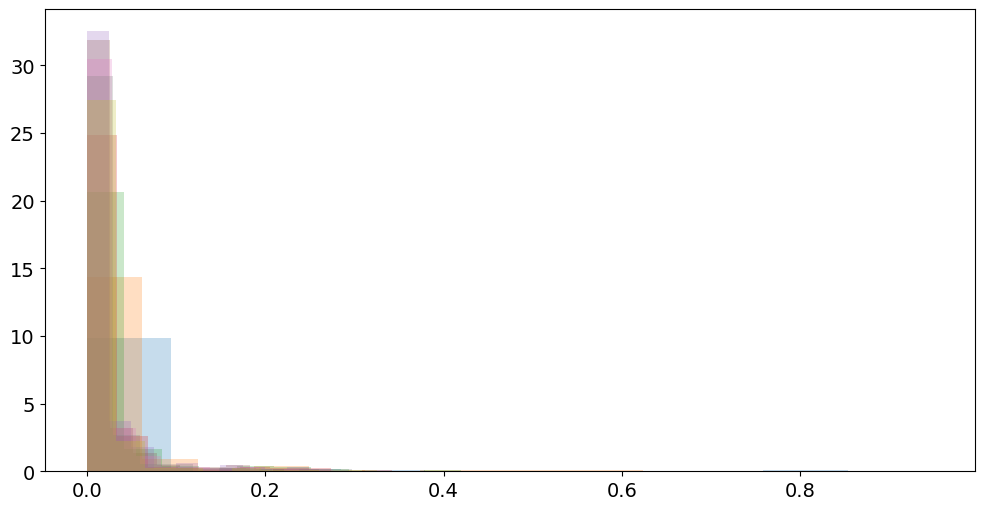

In [330]:
sample_0_r1 = []
sample_1_r1 = []
sample_2_r1 = []
sample_3_r1 = []
sample_4_r1 = []
sample_5_r1 = []
sample_6_r1 = []
sample_7_r1 = []
sample_8_r1 = []
sample_9_r1 = []
for i in range(len(r_1)):
    for j in range(len(r_1[i])):
        sample_0_r1.append(r_1[i][j][0])
        sample_1_r1.append(r_1[i][j][1])
        sample_2_r1.append(r_1[i][j][2])
        sample_3_r1.append(r_1[i][j][3])
        sample_4_r1.append(r_1[i][j][4])
        sample_5_r1.append(r_1[i][j][5])
        sample_6_r1.append(r_1[i][j][6])
        sample_7_r1.append(r_1[i][j][7])
        sample_8_r1.append(r_1[i][j][8])
        sample_9_r1.append(r_1[i][j][9])

#plt.hist(sample_0_r1, density = True, alpha = 0.25)
plt.hist(sample_1_r1, density = True, alpha = 0.25)
plt.hist(sample_2_r1, density = True, alpha = 0.25)
plt.hist(sample_3_r1, density = True, alpha = 0.25)
plt.hist(sample_4_r1, density = True, alpha = 0.25)
plt.hist(sample_5_r1, density = True, alpha = 0.25)
plt.hist(sample_6_r1, density = True, alpha = 0.25)
plt.hist(sample_7_r1, density = True, alpha = 0.25)
plt.hist(sample_8_r1, density = True, alpha = 0.25)
plt.hist(sample_9_r1, density = True, alpha = 0.25)

(array([39.95424164,  5.40443848,  0.77206264,  0.19301566,  0.77206264,
         0.57904698,  0.        ,  0.        ,  0.        ,  0.38603132]),
 array([0.        , 0.02080693, 0.04161387, 0.0624208 , 0.08322774,
        0.10403467, 0.12484161, 0.14564854, 0.16645548, 0.18726241,
        0.20806935]),
 <BarContainer object of 10 artists>)

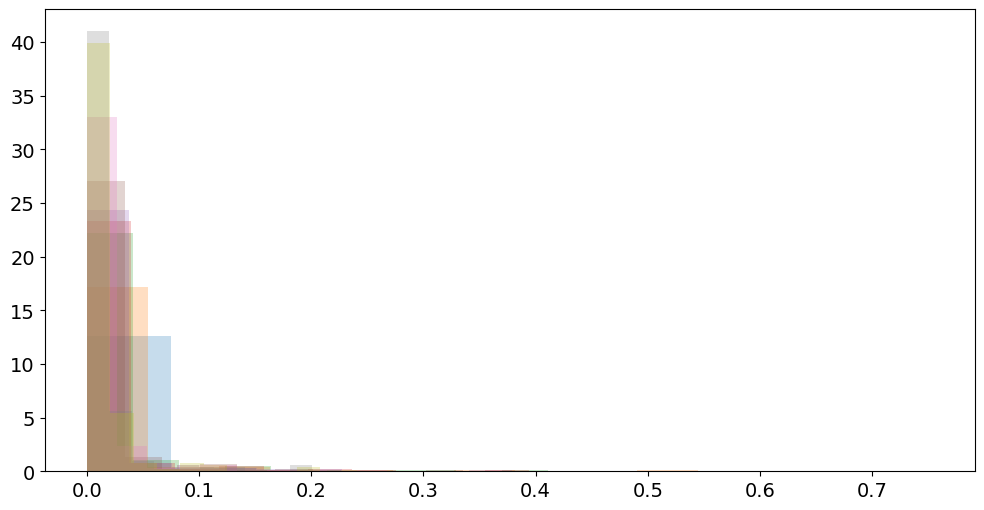

In [331]:
sample_0_r2 = []
sample_1_r2 = []
sample_2_r2 = []
sample_3_r2 = []
sample_4_r2 = []
sample_5_r2 = []
sample_6_r2 = []
sample_7_r2 = []
sample_8_r2 = []
sample_9_r2 = []
for i in range(len(r_2)):
    for j in range(len(r_2[i])):
        sample_0_r2.append(r_2[i][j][0])
        sample_1_r2.append(r_2[i][j][1])
        sample_2_r2.append(r_2[i][j][2])
        sample_3_r2.append(r_2[i][j][3])
        sample_4_r2.append(r_2[i][j][4])
        sample_5_r2.append(r_2[i][j][5])
        sample_6_r2.append(r_2[i][j][6])
        sample_7_r2.append(r_2[i][j][7])
        sample_8_r2.append(r_2[i][j][8])
        sample_9_r2.append(r_2[i][j][9])

#plt.hist(sample_0_r2, density = True, alpha = 0.25)
plt.hist(sample_1_r2, density = True, alpha = 0.25)
plt.hist(sample_2_r2, density = True, alpha = 0.25)
plt.hist(sample_3_r2, density = True, alpha = 0.25)
plt.hist(sample_4_r2, density = True, alpha = 0.25)
plt.hist(sample_5_r2, density = True, alpha = 0.25)
plt.hist(sample_6_r2, density = True, alpha = 0.25)
plt.hist(sample_7_r2, density = True, alpha = 0.25)
plt.hist(sample_8_r2, density = True, alpha = 0.25)
plt.hist(sample_9_r2, density = True, alpha = 0.25)

(array([42.86226953,  3.73570239,  0.39323183,  0.39323183,  0.58984775,
         0.39323183,  0.        ,  0.39323183,  0.        ,  0.19661592]),
 array([0.        , 0.02042594, 0.04085187, 0.06127781, 0.08170375,
        0.10212968, 0.12255562, 0.14298156, 0.16340749, 0.18383343,
        0.20425937]),
 <BarContainer object of 10 artists>)

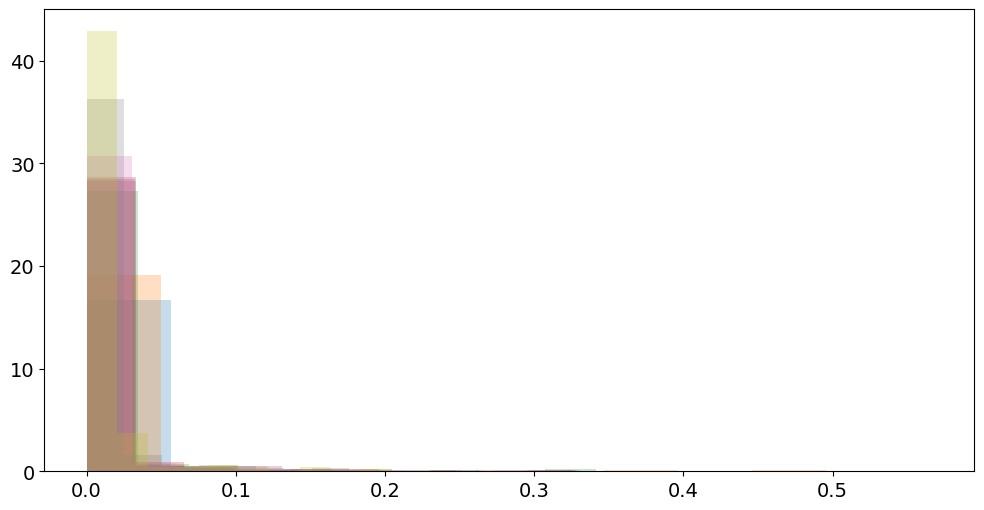

In [332]:
sample_0_r3 = []
sample_1_r3 = []
sample_2_r3 = []
sample_3_r3 = []
sample_4_r3 = []
sample_5_r3 = []
sample_6_r3 = []
sample_7_r3 = []
sample_8_r3 = []
sample_9_r3 = []
for i in range(len(r_3)):
    for j in range(len(r_3[i])):
        sample_0_r3.append(r_3[i][j][0])
        sample_1_r3.append(r_3[i][j][1])
        sample_2_r3.append(r_3[i][j][2])
        sample_3_r3.append(r_3[i][j][3])
        sample_4_r3.append(r_3[i][j][4])
        sample_5_r3.append(r_3[i][j][5])
        sample_6_r3.append(r_3[i][j][6])
        sample_7_r3.append(r_3[i][j][7])
        sample_8_r3.append(r_3[i][j][8])
        sample_9_r3.append(r_3[i][j][9])

#plt.hist(sample_0_r3, density = True, alpha = 0.25)
plt.hist(sample_1_r3, density = True, alpha = 0.25)
plt.hist(sample_2_r3, density = True, alpha = 0.25)
plt.hist(sample_3_r3, density = True, alpha = 0.25)
plt.hist(sample_4_r3, density = True, alpha = 0.25)
plt.hist(sample_5_r3, density = True, alpha = 0.25)
plt.hist(sample_6_r3, density = True, alpha = 0.25)
plt.hist(sample_7_r3, density = True, alpha = 0.25)
plt.hist(sample_8_r3, density = True, alpha = 0.25)
plt.hist(sample_9_r3, density = True, alpha = 0.25)

(array([42.86226953,  3.73570239,  0.39323183,  0.39323183,  0.58984775,
         0.39323183,  0.        ,  0.39323183,  0.        ,  0.19661592]),
 array([0.        , 0.02042594, 0.04085187, 0.06127781, 0.08170375,
        0.10212968, 0.12255562, 0.14298156, 0.16340749, 0.18383343,
        0.20425937]),
 <BarContainer object of 10 artists>)

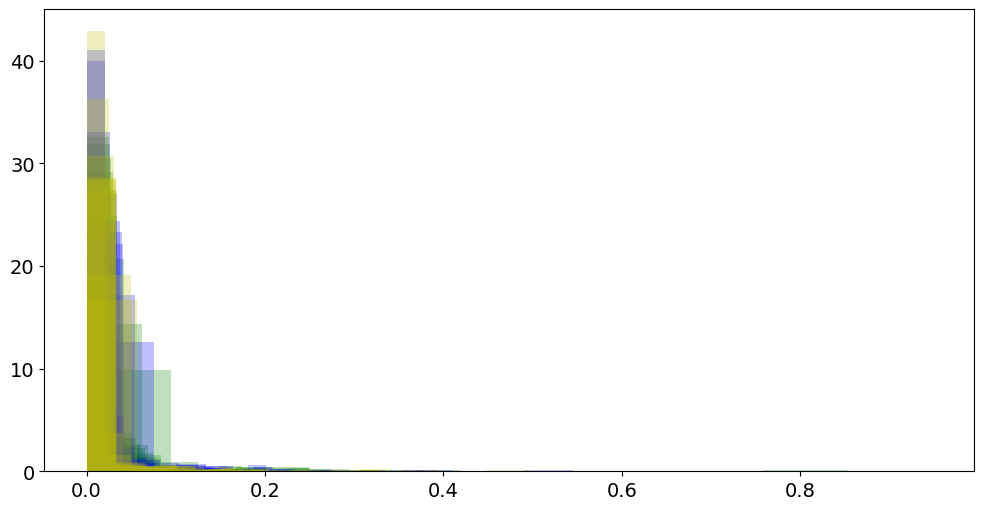

In [336]:
#plt.hist(sample_0_r1, density = True, alpha = 0.25)
plt.hist(sample_1_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_2_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_3_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_4_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_5_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_6_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_7_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_8_r1, density = True, alpha = 0.25, color = 'g')
plt.hist(sample_9_r1, density = True, alpha = 0.25, color = 'g')

#plt.hist(sample_0_r1, density = True, alpha = 0.25)
plt.hist(sample_1_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_2_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_3_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_4_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_5_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_6_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_7_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_8_r2, density = True, alpha = 0.25, color = 'b')
plt.hist(sample_9_r2, density = True, alpha = 0.25, color = 'b')


#plt.hist(sample_0_r3, density = True, alpha = 0.25)
plt.hist(sample_1_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_2_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_3_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_4_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_5_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_6_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_7_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_8_r3, density = True, alpha = 0.25, color = 'y')
plt.hist(sample_9_r3, density = True, alpha = 0.25, color = 'y')

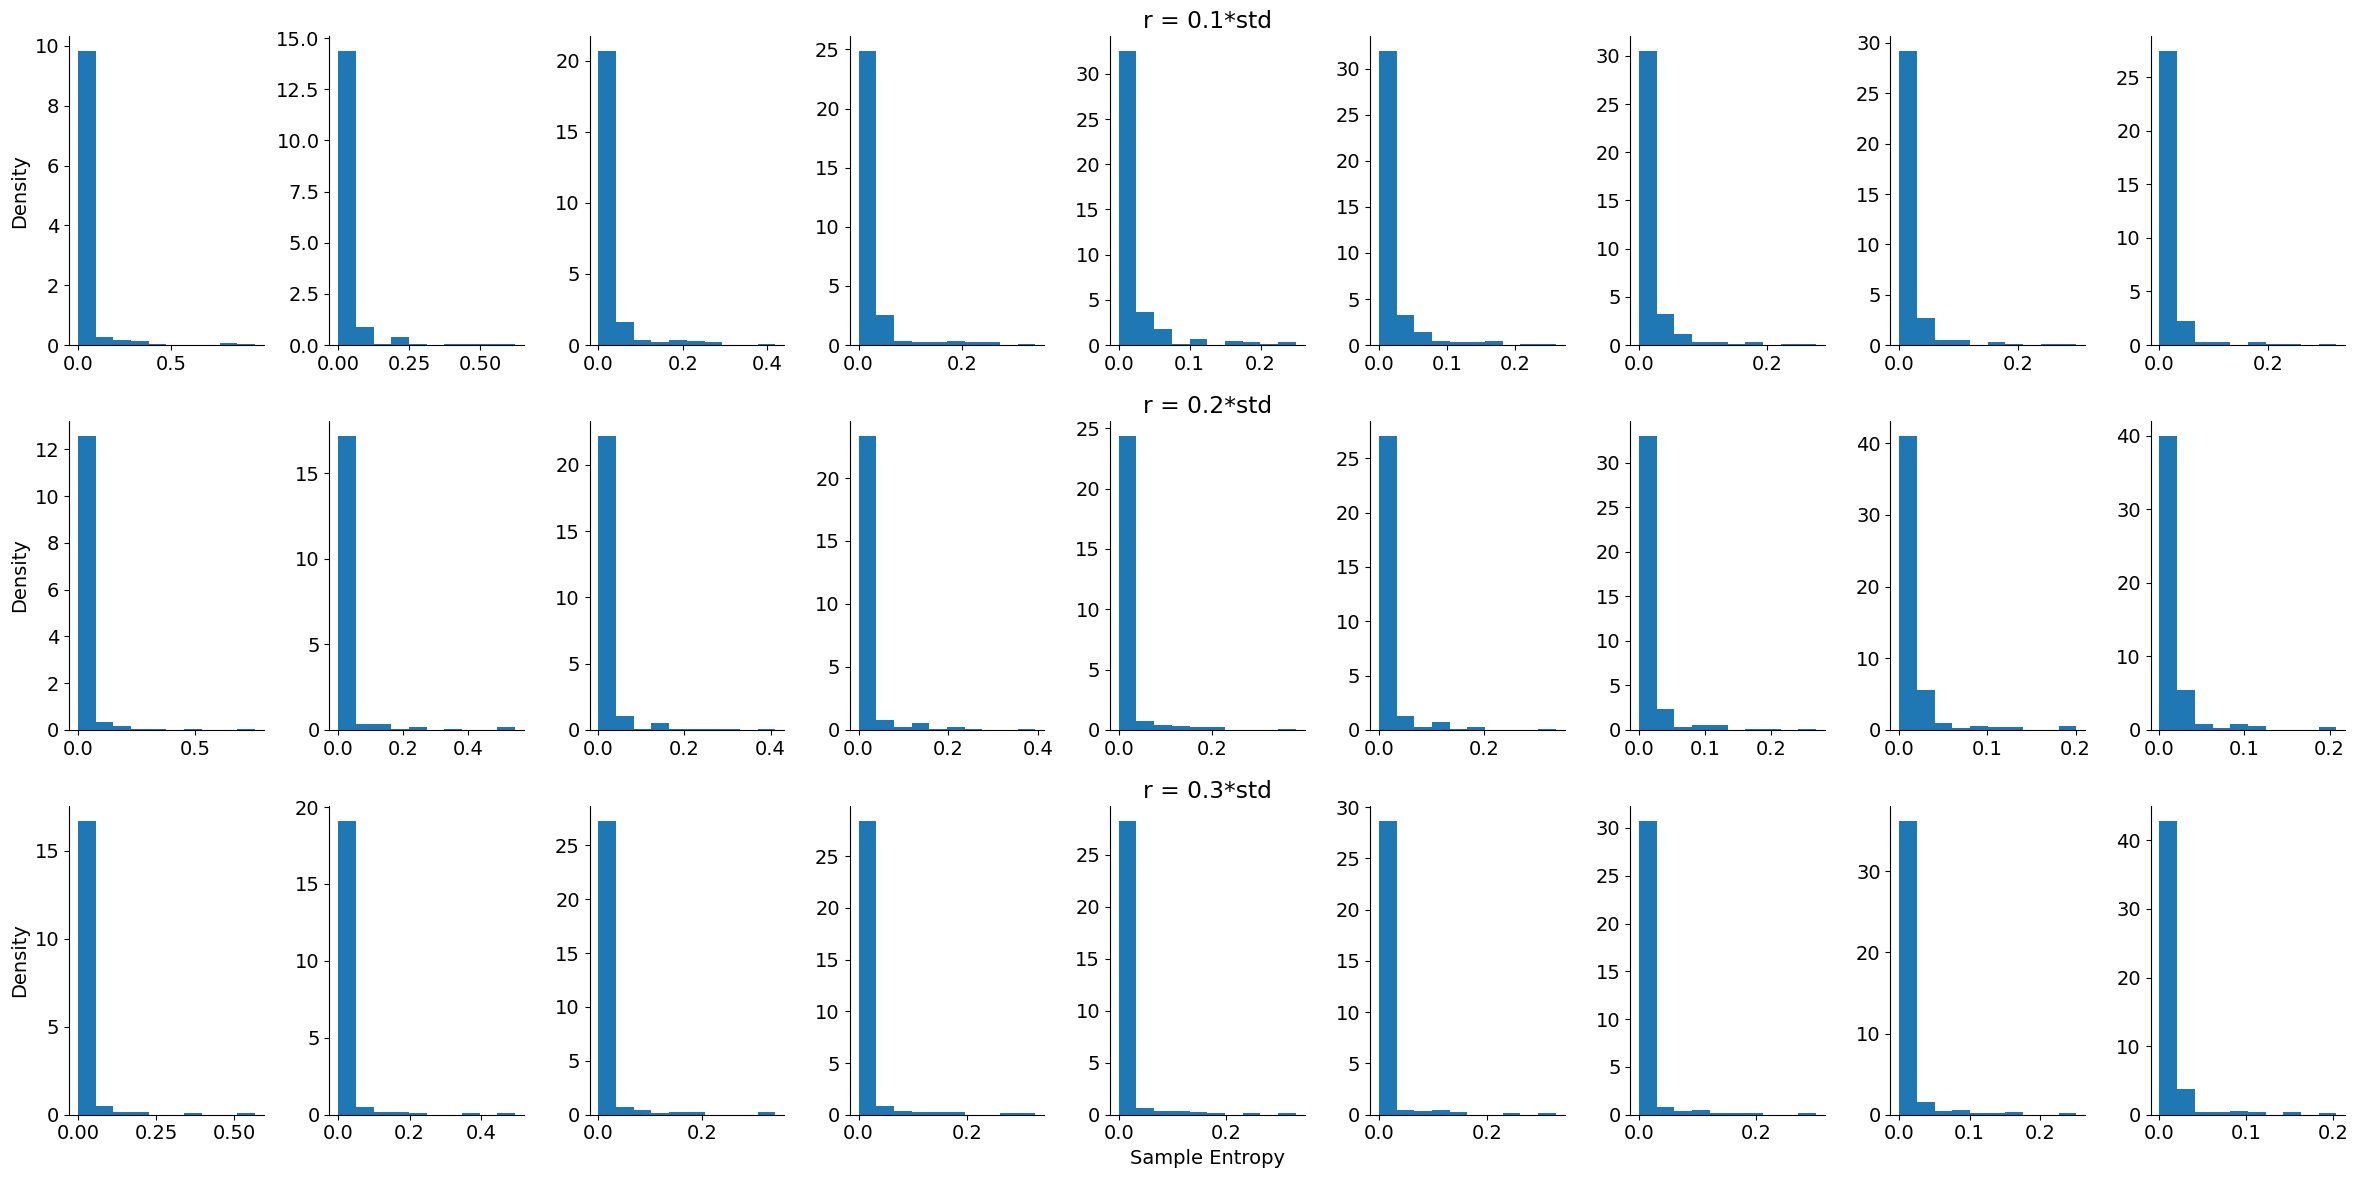

In [353]:
plt.rcParams['figure.figsize'] = (24,12)
fig, axes = plt.subplots(3,9)
sample_entropy_list = []
sample_entropy_list.append(sample_1_r1)
sample_entropy_list.append(sample_2_r1)
sample_entropy_list.append(sample_3_r1)
sample_entropy_list.append(sample_4_r1)
sample_entropy_list.append(sample_5_r1)
sample_entropy_list.append(sample_6_r1)
sample_entropy_list.append(sample_7_r1)
sample_entropy_list.append(sample_8_r1)
sample_entropy_list.append(sample_9_r1)
sample_entropy_list.append(sample_1_r2)
sample_entropy_list.append(sample_2_r2)
sample_entropy_list.append(sample_3_r2)
sample_entropy_list.append(sample_4_r2)
sample_entropy_list.append(sample_5_r2)
sample_entropy_list.append(sample_6_r2)
sample_entropy_list.append(sample_7_r2)
sample_entropy_list.append(sample_8_r2)
sample_entropy_list.append(sample_9_r2)
sample_entropy_list.append(sample_1_r3)
sample_entropy_list.append(sample_2_r3)
sample_entropy_list.append(sample_3_r3)
sample_entropy_list.append(sample_4_r3)
sample_entropy_list.append(sample_5_r3)
sample_entropy_list.append(sample_6_r3)
sample_entropy_list.append(sample_7_r3)
sample_entropy_list.append(sample_8_r3)
sample_entropy_list.append(sample_9_r3)
title_list = ['r = 0.1*std', 'r = 0.2*std', 'r = 0.3*std']
for ax, i, col in zip(axes.flatten(),  range(27), sample_entropy_list):
    ax.hist(col, density = True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i%27 == 4:
        ax.set_title(title_list[0])
    if i%27 == 13:
        ax.set_title(title_list[1])
    if i%27 == 22:
        ax.set_title(title_list[2])
    if i%27 == 22:
        ax.set_xlabel('Sample Entropy')
    if i%9 == 0:
        ax.set_ylabel('Density')
plt.tight_layout()
plt.savefig('sampen_diff_m_r.svg')

Text(0.5, 0.98, 'Histograms comparing permutation entropy and sample entropy')

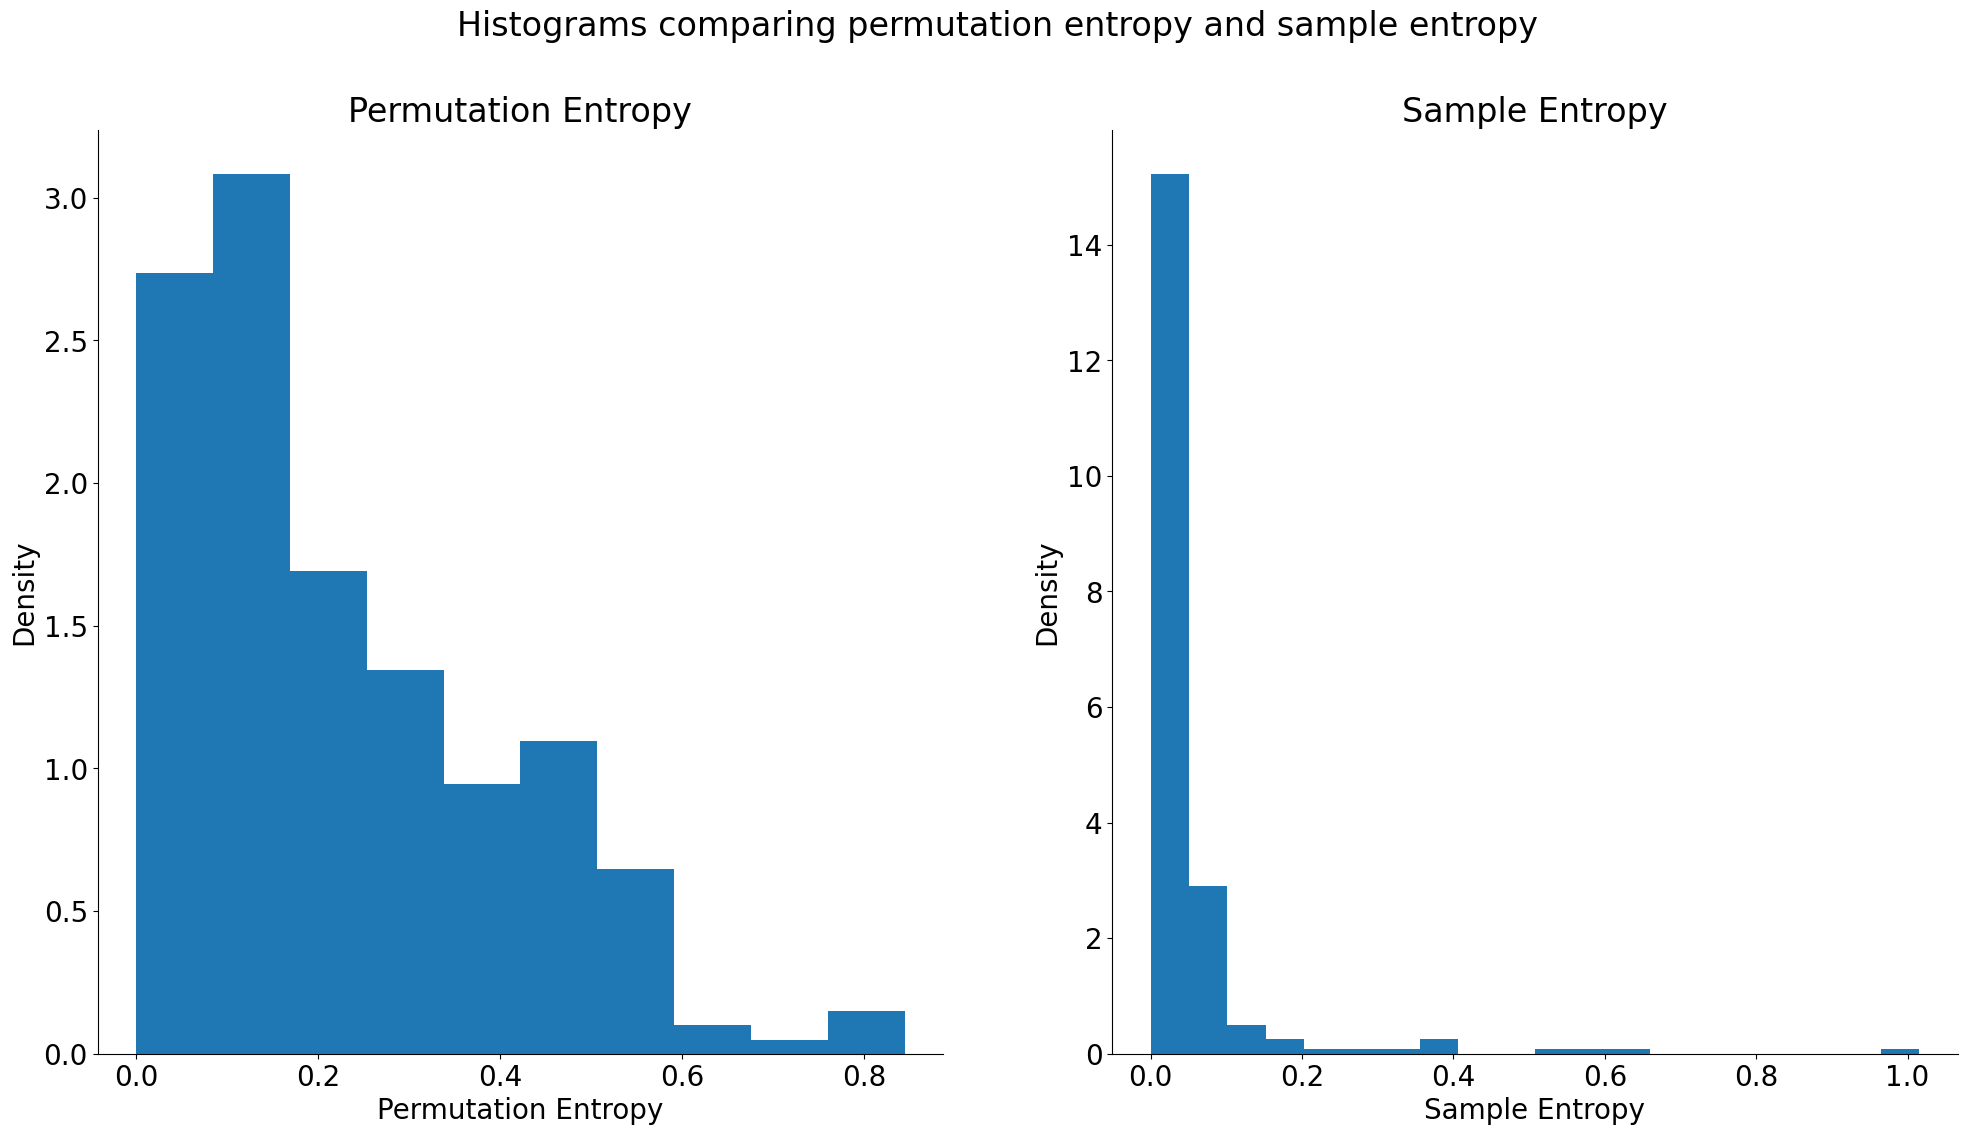

In [381]:
fig, ax = plt.subplots(1,2)
plt.rcParams['font.size'] = 20
ax[0].hist(flatten(entropy_list_all_dx[0]), density = True)
ax[0].set_title('Permutation Entropy')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Permutation Entropy')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].hist(flatten(sample_entropy_list_all_default), density = True, bins = 20)
ax[1].set_title('Sample Entropy')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Sample Entropy')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.suptitle('Histograms comparing permutation entropy and sample entropy')

# Approximate Entropy

In [224]:
dx_list = 10
approx_entropy_list_all = []
for i in tqdm(range(len(rating_all))):
    approx_entropy_list = approx_entropy_func(rating_all[i], dx)
    approx_entropy_list_all.append(approx_entropy_list)

  0%|          | 0/79 [00:00<?, ?it/s]

In [228]:
np.save('ApEn_list.npy',np.array(approx_entropy_list_all))

C:\Users\sharonho\AppData\Local\Temp\ipykernel_31604\825820053.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('ApEn_list.npy',np.array(approx_entropy_list_all))


(array([20.92480041,  7.94612674,  2.11896713,  0.66217723,  0.52974178,
         0.13243545,  0.39730634,  0.13243545,  0.        ,  0.13243545]),
 array([0.        , 0.03032469, 0.06064939, 0.09097408, 0.12129877,
        0.15162347, 0.18194816, 0.21227285, 0.24259755, 0.27292224,
        0.30324693]),
 <BarContainer object of 10 artists>)

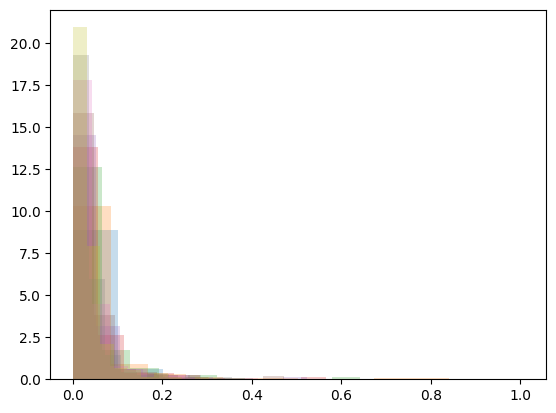

In [227]:
approx_0 = []
approx_1 = []
approx_2 = []
approx_3 = []
approx_4 = []
approx_5 = []
approx_6 = []
approx_7 = []
approx_8 = []
approx_9 = []
for i in range(len(approx_entropy_list_all)):
    for j in range(len(approx_entropy_list_all[i])):
        approx_0.append(approx_entropy_list_all[i][j][0])
        approx_1.append(approx_entropy_list_all[i][j][1])
        approx_2.append(approx_entropy_list_all[i][j][2])
        approx_3.append(approx_entropy_list_all[i][j][3])
        approx_4.append(approx_entropy_list_all[i][j][4])
        approx_5.append(approx_entropy_list_all[i][j][5])
        approx_6.append(approx_entropy_list_all[i][j][6])
        approx_7.append(approx_entropy_list_all[i][j][7])
        approx_8.append(approx_entropy_list_all[i][j][8])
        approx_9.append(approx_entropy_list_all[i][j][9])
#plt.hist(approx_0, density = True, alpha = 0.25)
plt.hist(approx_1, density = True, alpha = 0.25)
plt.hist(approx_2, density = True, alpha = 0.25)
plt.hist(approx_3, density = True, alpha = 0.25)
plt.hist(approx_4, density = True, alpha = 0.25)
plt.hist(approx_5, density = True, alpha = 0.25)
plt.hist(approx_6, density = True, alpha = 0.25)
plt.hist(approx_7, density = True, alpha = 0.25)
plt.hist(approx_8, density = True, alpha = 0.25)
plt.hist(approx_9, density = True, alpha = 0.25)

In [ ]:
dr_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35]
dx = 10
approx_entropy_list_all_dr = []
for dr in dr_list:
    approx_entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        approx_entropy_list = approx_entropy_func_heatmap(rating_all[i], dx, dr)
        approx_entropy_list_all.append(approx_entropy_list)
    approx_entropy_list_all_dr.append(approx_entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.save('ApEn_dr.npy', approx_entropy_list_all_dr)

In [ ]:
approx_0 = []
approx_1 = []
approx_2 = []
approx_3 = []
approx_4 = []
approx_5 = []
approx_6 = []
approx_7 = []
approx_8 = []
approx_9 = []
for i in range(len(approx_entropy_list_all_dr)):
    for j in range(len(approx_entropy_list_all_dr[i])):
        approx_0.append(approx_entropy_list_all_dr[i][j][0])
        approx_1.append(approx_entropy_list_all_dr[i][j][1])
        approx_2.append(approx_entropy_list_all_dr[i][j][2])
        approx_3.append(approx_entropy_list_all_dr[i][j][3])
        approx_4.append(approx_entropy_list_all_dr[i][j][4])
        approx_5.append(approx_entropy_list_all_dr[i][j][5])
        approx_6.append(approx_entropy_list_all_dr[i][j][6])
        approx_7.append(approx_entropy_list_all_dr[i][j][7])
        approx_8.append(approx_entropy_list_all_dr[i][j][8])
        approx_9.append(approx_entropy_list_all_dr[i][j][9])
#plt.hist(approx_0, density = True, alpha = 0.25)
plt.hist(approx_1, density = True, alpha = 0.25)
plt.hist(approx_2, density = True, alpha = 0.25)
plt.hist(approx_3, density = True, alpha = 0.25)
plt.hist(approx_4, density = True, alpha = 0.25)
plt.hist(approx_5, density = True, alpha = 0.25)
plt.hist(approx_6, density = True, alpha = 0.25)
plt.hist(approx_7, density = True, alpha = 0.25)
plt.hist(approx_8, density = True, alpha = 0.25)
plt.hist(approx_9, density = True, alpha = 0.25)

# Multiscale entropy

In [312]:
dr_list = [0.1,0.2,0.3]
dx = 3
scale = 5
multiscale_entropy_list_all_dr_dx3 = []
for dr in dr_list:
    multi_entropy_list_all = []
    for i in tqdm(range(len(rating_all))):
        multi_entropy_list = multiscale_entropy_func_heatmap(rating_all[i], dx, dr, scale)
        multi_entropy_list_all.append(multi_entropy_list)
    multiscale_entropy_list_all_dr_dx3.append(multi_entropy_list_all)

  0%|          | 0/79 [00:00<?, ?it/s]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

  0%|          | 0/79 [00:00<?, ?it/s]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

  0%|          | 0/79 [00:00<?, ?it/s]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [313]:
np.save('MSEn_heatmap_scale5_dx3.npy', multiscale_entropy_list_all_dr_dx3)

c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [527]:
multiscale_entropy_5_dx2_dr3std = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        multiscale_entropy_5_dx2_dr3std.append(multiscale_entropy_list_all_dr[2][i][j][4])
multiscale_entropy_4_dx2_dr3std = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        multiscale_entropy_5_dx2_dr3std.append(multiscale_entropy_list_all_dr[2][i][j][4])



In [577]:
multiscale_entropy_5_dx2_dr3std = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        multiscale_entropy_5_dx2_dr3std.append(multiscale_entropy_list_all_dr[2][i][j][1])

In [581]:
multiscale_entropy_5_dx2_dr3std = []
multiscale_entropy_5_dx2_dr3std_overall = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    multiscale_entropy_5_dx2_dr3std_part = []
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        multiscale_entropy_5_dx2_dr3std_part.append(multiscale_entropy_list_all_dr[0][i][j][0])
    multiscale_entropy_5_dx2_dr3std.append(multiscale_entropy_5_dx2_dr3std_part)
    multiscale_entropy_5_dx2_dr3std_overall.append(np.mean(multiscale_entropy_5_dx2_dr3std_part))
multiscale_entropy_5_dx2_dr3std_overall

[0.008400419808532239,
 0.0001300669593114159,
 0.0960970630869888,
 0.004882469773479843,
 0.006534754023316474,
 0.0007151451971165302,
 0.010450802756250642,
 0.0034518850494510427,
 0.37734201340089385,
 0.07578551345710063,
 0.0013367165209180775,
 0.0254060822343266,
 0.00845745022909163,
 0.004360770133909721,
 0.01974488137624657,
 0.01893007079284591,
 0.01696303146741109,
 0.0009541195640753262,
 0.003026126628419889,
 0.002788575218089661,
 0.004275210527793791,
 0.005975060335583493,
 0.034107942381981886,
 0.12201900757771651,
 0.003401138483514279,
 0.0027883015385090056,
 0.1334982036508934,
 0.0356306357192704,
 0.019180006033477106,
 0.02311050171533749,
 0.03993162038909767,
 0.008725630655711867,
 0.001367288931474108,
 0.004380133939023883,
 0.008585298931885489,
 0.0027461798740381787,
 0.006095163309198735,
 0.018857105223086187,
 0.02539444646032,
 0.059549188446938704,
 0.0038378013261138387,
 0.03250253521780185,
 0.00696991860394923,
 0.01780939182655496,
 0.0

# Random correlation of different scales

In [582]:
participant_list = data['PID'].unique()
mean_list_all = []

variance_list_all = []


for j in range(len(rating_all)):
    mean_list = mean(rating_all[j])

    variance_list= variance(rating_all[j], time_all[j])
    mean_list_all.append(mean_list)
    variance_list_all.append(variance_list)
mean_overall = []
for i in range(len(mean_list_all)):
    mean_overall.append(np.mean(mean_list_all[i]))
def var_all(rating):
    if len(rating) == 1:
        rating_collected = rating[0]
    elif len(rating) == 2:
        rating_collected = np.hstack([rating[0], rating[1]])
    elif len(rating) == 3:
        rating_collected = np.hstack([rating[0], rating[1], rating[2]])
    elif len(rating) == 4:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3]])
    elif len(rating) == 5:
        rating_collected = np.hstack([rating[0], rating[1], rating[2], rating[3], rating[4]])
    else: 
        rating_collected = np.nan
    return np.var(rating_collected)
var_combined_list_all = []
for j in range(len(rating_all)):
    var_combined_list = var_all(rating_all[j])
    var_combined_list_all.append(var_combined_list)


#list all the data files and its path
questionnaire = []
onlyfiles = [f for f in listdir('../Data/questionnaire') if isfile(join('../Data/questionnaire', f))]
for i in range(len(onlyfiles)):
    path = '../Data/questionnaire/' + onlyfiles[i]
    questionnaire.append(path)


df_questionnaire_pre = pd.read_csv(questionnaire[0])
df_questionnaire_s1 = pd.read_csv(questionnaire[1])
df_questionnaire_s2 = pd.read_csv(questionnaire[2])
index_pre = []
for id in participant_list:
    index_pre.append(np.where(df_questionnaire_pre.PROLIFIC_PID == id)[0][0])
index_s1 = []
for id in participant_list:
    index_s1.append(np.where(df_questionnaire_s1.PROLIFIC_PID == id)[0])
index_s2 = []
for id in participant_list:
    index_s2.append(np.where(df_questionnaire_s2.PROLIFIC_PID == id)[0])
df_questionnaire_index_pre = df_questionnaire_pre.iloc[index_pre]
msk_scores = df_questionnaire_index_pre['Score'].values
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_overall)[s1_questionnaire_index]
var_s1 = np.array(var_combined_list_all)[s1_questionnaire_index]
MSE_s1 = np.array(multiscale_entropy_5_dx2_dr3std_overall)[s1_questionnaire_index]
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_overall)[s2_questionnaire_index]
var_s2 = np.array(var_combined_list_all)[s2_questionnaire_index]
MSE_s2 = np.array(multiscale_entropy_5_dx2_dr3std_overall)[s2_questionnaire_index]
msk_scores_lastq = np.load('msk_last_q.npy')

c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [583]:
fractal_mskscores = zip(multiscale_entropy_5_dx2_dr3std_overall, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_RS = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk)
print(bf_fractal_msk)


fractal_mskscores_lastq = zip(multiscale_entropy_5_dx2_dr3std_overall, msk_scores_lastq)
x = []; y=[]
for point in list(fractal_mskscores_lastq):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores_lastq = np.corrcoef(x,y)
print(corr_fractal_mskscores_lastq)
bf_fractal_msk_lastq = pingouin.bayesfactor_pearson(corr_fractal_mskscores_lastq[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk_lastq)
print(bf_fractal_msk_lastq)

fractal_mean = zip(multiscale_entropy_5_dx2_dr3std_overall, mean_overall)
x = []; y=[]
for point in list(fractal_mean):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_RS.append(bf_fractal_mean)
print(bf_fractal_mean)



fractal_var = zip(multiscale_entropy_5_dx2_dr3std_overall, var_combined_list_all)
x = []; y=[]
for point in list(fractal_var):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_RS.append(bf_fractal_var)
print(bf_fractal_var)


bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(MSE_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)


bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(MSE_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)



back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(MSE_s1, start_total)
x = []; y=[]
for point in list(fractal_start):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_RS.append(bf_fractal_start)
print(bf_fractal_start)



back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(MSE_s1, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_RS.append(bf_fractal_startsub)
print(bf_fractal_startsub)



pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(MSE_s2, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)



pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(MSE_s2, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)



pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(MSE_s2, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)



pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(MSE_s2, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)



gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(MSE_s2, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_RS.append(bf_fractal_gad7)
print(bf_fractal_gad7)


phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(MSE_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   x.append(point[0])
   y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_RS.append(bf_fractal_phq9)
print(bf_fractal_phq9)
if np.max(fractal_bf_RS) > 1:
   print('True')
else:
   print('False')



[[1.         0.06510037]
 [0.06510037 1.        ]]
0.16487021957684989
[[ 1.         -0.06814528]
 [-0.06814528  1.        ]]
0.16741296594034857
[[1.         0.01839451]
 [0.01839451 1.        ]]
0.14324086468293787
[[ 1.        -0.0045619]
 [-0.0045619  1.       ]]
0.14156491315713485
[[1.         0.05857392]
 [0.05857392 1.        ]]
0.17002614543080005
[[1.         0.00103561]
 [0.00103561 1.        ]]
0.15255161086750174
[[ 1.         -0.20874854]
 [-0.20874854  1.        ]]
0.470371465694512
[[ 1.         -0.19246681]
 [-0.19246681  1.        ]]
0.4074677352326506
[[ 1.         -0.11589865]
 [-0.11589865  1.        ]]
0.23488004956575342
[[ 1.         -0.07595572]
 [-0.07595572  1.        ]]
0.18481714846023067
[[ 1.        -0.1780843]
 [-0.1780843  1.       ]]
0.41124914781993294
[[ 1.         -0.09768603]
 [-0.09768603  1.        ]]
0.2088318639558838
[[ 1.         -0.05214196]
 [-0.05214196  1.        ]]
0.17046206695823013
[[ 1.         -0.07442254]
 [-0.07442254  1.        ]

# Don't combine them!

In [585]:
multiscale_entropy_5_dx2_dr3std = []
multiscale_entropy_5_dx2_dr3std_overall = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    multiscale_entropy_5_dx2_dr3std_part = []
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        multiscale_entropy_5_dx2_dr3std_part.append(multiscale_entropy_list_all_dr[0][i][j][0])
    multiscale_entropy_5_dx2_dr3std.append(multiscale_entropy_5_dx2_dr3std_part)
    multiscale_entropy_5_dx2_dr3std_overall.append(np.mean(multiscale_entropy_5_dx2_dr3std_part))
multiscale_entropy_5_dx2_dr3std

participant_list = data['PID'].unique()
mean_list_all = []

variance_list_all = []


for j in range(len(rating_all)):
    mean_list = mean(rating_all[j])

    variance_list= variance(rating_all[j], time_all[j])
    mean_list_all.append(mean_list)
    variance_list_all.append(variance_list)



#list all the data files and its path
questionnaire = []
onlyfiles = [f for f in listdir('../Data/questionnaire') if isfile(join('../Data/questionnaire', f))]
for i in range(len(onlyfiles)):
    path = '../Data/questionnaire/' + onlyfiles[i]
    questionnaire.append(path)


df_questionnaire_pre = pd.read_csv(questionnaire[0])
df_questionnaire_s1 = pd.read_csv(questionnaire[1])
df_questionnaire_s2 = pd.read_csv(questionnaire[2])
index_pre = []
for id in participant_list:
    index_pre.append(np.where(df_questionnaire_pre.PROLIFIC_PID == id)[0][0])
index_s1 = []
for id in participant_list:
    index_s1.append(np.where(df_questionnaire_s1.PROLIFIC_PID == id)[0])
index_s2 = []
for id in participant_list:
    index_s2.append(np.where(df_questionnaire_s2.PROLIFIC_PID == id)[0])
df_questionnaire_index_pre = df_questionnaire_pre.iloc[index_pre]
msk_scores = df_questionnaire_index_pre['Score'].values
index_s1_normal = []
for i in range(len(index_s1)):
    if len(index_s1[i]) == 1:
        index_s1_normal.append(index_s1[i][0])
df_s1_normal = df_questionnaire_s1.iloc[index_s1_normal]
participant_list_s1_questionnaire = df_s1_normal.PROLIFIC_PID.values#.to_list()
s1_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s1_questionnaire:
        s1_questionnaire_index.append(i)
mean_s1 = np.array(mean_list_all)[s1_questionnaire_index]
var_s1 = np.array(variance_list_all)[s1_questionnaire_index]
MSE_s1 = np.array(multiscale_entropy_5_dx2_dr3std)[s1_questionnaire_index]
index_s2_normal = []
for i in range(len(index_s2)):
    if len(index_s2[i]) == 1:
        index_s2_normal.append(index_s2[i][0])
df_s2_normal = df_questionnaire_s2.iloc[index_s2_normal]
participant_list_s2_questionnaire = df_s2_normal.PROLIFIC_PID.values#.to_list()
s2_questionnaire_index = []
for i in range(len(participant_list)):
    if participant_list[i] in participant_list_s2_questionnaire:
        s2_questionnaire_index.append(i)
mean_s2 = np.array(mean_list_all)[s2_questionnaire_index]
var_s2 = np.array(variance_list_all)[s2_questionnaire_index]
MSE_s2 = np.array(multiscale_entropy_5_dx2_dr3std)[s2_questionnaire_index]
msk_scores_lastq = np.load('msk_last_q.npy')

c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sharonho\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sharonho\AppData\Local\Temp\ipykernel_31604\2522375578.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_s1 = np.array(mean_list_all)[s1_questionnaire_index]
C:\Users\sharonho\AppData\Local\Temp\ipykernel_31604\2522375578.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

In [602]:
print('msk scores')
fractal_mskscores = zip(multiscale_entropy_5_dx2_dr3std, msk_scores)
x = []; y=[]
for point in list(fractal_mskscores):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores = np.corrcoef(x,y)
print(corr_fractal_mskscores)
fractal_bf_RS = []
bf_fractal_msk = pingouin.bayesfactor_pearson(corr_fractal_mskscores[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk)
print(bf_fractal_msk)

print('------')
print('no of active days')
fractal_mskscores_lastq = zip(multiscale_entropy_5_dx2_dr3std, msk_scores_lastq)
x = []; y=[]
for point in list(fractal_mskscores_lastq):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mskscores_lastq = np.corrcoef(x,y)
print(corr_fractal_mskscores_lastq)
bf_fractal_msk_lastq = pingouin.bayesfactor_pearson(corr_fractal_mskscores_lastq[0][1], len(x))
fractal_bf_RS.append(bf_fractal_msk_lastq)
print(bf_fractal_msk_lastq)

print('------')
print('mean')
fractal_mean = zip(multiscale_entropy_5_dx2_dr3std, mean_list_all)
x = []; y=[]
for point in list(fractal_mean):
   for i in range(len(point[0])):
      if len(point[0]) == len(point[1]):
         x.append(point[0][i])
         y.append(point[1][i])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_mean = np.corrcoef(x,y)
print(corr_fractal_mean)
bf_fractal_mean = pingouin.bayesfactor_pearson(corr_fractal_mean[0][1], len(x))
fractal_bf_RS.append(bf_fractal_mean)
print(bf_fractal_mean)


print('------')
print('variance')
fractal_var = zip(multiscale_entropy_5_dx2_dr3std, variance_list_all)
x = []; y=[]
for point in list(fractal_var):
   for i in range(len(point[0])):
      if len(point[0]) == len(point[1]):
         x.append(point[0][i])
         y.append(point[1][i])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
x_bestfit = np.arange(0,11,0.1)
y_bestfit = a*x_bestfit+b
corr_fractal_var = np.corrcoef(x,y)
print(corr_fractal_var)
bf_fractal_var = pingouin.bayesfactor_pearson(corr_fractal_var[0][1], len(x))
fractal_bf_RS.append(bf_fractal_var)
print(bf_fractal_var)

print('------')
print('BPI mean severity')
bpi_mean_severity = df_s1_normal['BPI Mean Severity Score'].values
fractal_bpisev = zip(MSE_s1, bpi_mean_severity)
x = []; y=[]
for point in list(fractal_bpisev):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpisev = np.corrcoef(x,y)
print(corr_fractal_bpisev)
bf_fractal_bpisev = pingouin.bayesfactor_pearson(corr_fractal_bpisev[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpisev)
print(bf_fractal_bpisev)

print('------')
print('BPI mean interference')
bpi_mean_interference = df_s1_normal['BPI Mean Pain Interference Score'].values
fractal_bpiint = zip(MSE_s1, bpi_mean_interference)
x = []; y=[]
for point in list(fractal_bpiint):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_bpiint = np.corrcoef(x,y)
print(corr_fractal_bpiint)
bf_fractal_bpiint = pingouin.bayesfactor_pearson(corr_fractal_bpiint[0][1], len(x))
fractal_bf_RS.append(bf_fractal_bpiint)
print(bf_fractal_bpiint)


print('------')
print('start')
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_total = df_s1_normal['START total score'].iloc[back_pain].values
fractal_start = zip(MSE_s1, start_total)
x = []; y=[]
for point in list(fractal_start):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_start = np.corrcoef(x,y)
print(corr_fractal_start)
bf_fractal_start = pingouin.bayesfactor_pearson(corr_fractal_start[0][1], len(x))
fractal_bf_RS.append(bf_fractal_start)
print(bf_fractal_start)


print('------')
print('startsub')
back_pain = df_s1_normal['Back Pain'].values == 'Yes'
start_sub = df_s1_normal['START sub score'].iloc[back_pain].values
fractal_startsub = zip(MSE_s1, start_sub)
x = []; y=[]
for point in list(fractal_startsub):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
a, b = np.polyfit(x, y, 1)
corr_fractal_startsub = np.corrcoef(x,y)
print(corr_fractal_startsub)
bf_fractal_startsub = pingouin.bayesfactor_pearson(corr_fractal_startsub[0][1], len(x))
fractal_bf_RS.append(bf_fractal_startsub)
print(bf_fractal_startsub)


print('------')
print('PCS')
pcs_total = df_s2_normal['Total PCS Score'].values
fractal_pcs_total = zip(MSE_s2, pcs_total)
x = []; y=[]
for point in list(fractal_pcs_total):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_total = np.corrcoef(x,y)
print(corr_fractal_pcs_total)
bf_fractal_pcs_total = pingouin.bayesfactor_pearson(corr_fractal_pcs_total[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_total)
print(bf_fractal_pcs_total)


print('------')
print('PCS rum')
pcs_rum = df_s2_normal['PCS Rumination Score'].values
fractal_pcs_rum = zip(MSE_s2, pcs_rum)
x = []; y=[]
for point in list(fractal_pcs_rum):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_rum = np.corrcoef(x,y)
print(corr_fractal_pcs_rum)
bf_fractal_pcs_rum = pingouin.bayesfactor_pearson(corr_fractal_pcs_rum[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_rum)
print(bf_fractal_pcs_rum)


print('------')
print('PCS mag')
pcs_mag = df_s2_normal['PCS Magnification Score'].values
fractal_pcs_mag = zip(MSE_s2, pcs_mag)
x = []; y=[]
for point in list(fractal_pcs_mag):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_mag = np.corrcoef(x,y)
print(corr_fractal_pcs_mag)
bf_fractal_pcs_mag = pingouin.bayesfactor_pearson(corr_fractal_pcs_mag[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_mag)
print(bf_fractal_pcs_mag)


print('------')
print('PCS help')
pcs_help = df_s2_normal['PCS Helplessness Score'].values
fractal_pcs_help = zip(MSE_s2, pcs_help)
x = []; y=[]
for point in list(fractal_pcs_help):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_pcs_help = np.corrcoef(x,y)
print(corr_fractal_pcs_help)
bf_fractal_pcs_help = pingouin.bayesfactor_pearson(corr_fractal_pcs_help[0][1], len(x))
fractal_bf_RS.append(bf_fractal_pcs_help)
print(bf_fractal_pcs_help)


print('------')
print('gad7')
gad7_total = df_s2_normal['Total GAD7 Score'].values
fractal_gad7 = zip(MSE_s2, gad7_total)
x = []; y=[]
for point in list(fractal_gad7):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_gad7 = np.corrcoef(x,y)
print(corr_fractal_gad7)
bf_fractal_gad7 = pingouin.bayesfactor_pearson(corr_fractal_gad7[0][1], len(x))
fractal_bf_RS.append(bf_fractal_gad7)
print(bf_fractal_gad7)

print('------')
print('phq9')
phq9_total = df_s2_normal['Total PHQ9 Score'].values
fractal_phq9 = zip(MSE_s2, phq9_total)
x = []; y=[]
for point in list(fractal_phq9):
   for i in range(len(point[0])):
      x.append(point[0][i])
      y.append(point[1])
for i in range(len(y)):
   if pd.isnull(y[i]):
      x[i] = np.NaN
   if pd.isnull(x[i]):
      y[i] = np.NaN
x = pd.Series(x).dropna().to_list()
y = pd.Series(y).dropna().to_list()
corr_fractal_phq9 = np.corrcoef(x,y)
print(corr_fractal_phq9)
bf_fractal_phq9 = pingouin.bayesfactor_pearson(corr_fractal_phq9[0][1], len(x))
fractal_bf_RS.append(bf_fractal_phq9)
print(bf_fractal_phq9)
if np.max(fractal_bf_RS) > 1:
   print('True')
else:
   print('False')



msk scores
[[1.         0.06490644]
 [0.06490644 1.        ]]
0.13309396995460174
------
no of active days
[[ 1.         -0.04253283]
 [-0.04253283  1.        ]]
0.09905317790750416
------
mean
[[ 1.         -0.01770692]
 [-0.01770692  1.        ]]
0.08622731204668638
------
variance
[[1.         0.01598782]
 [0.01598782 1.        ]]
0.0856744257587283
------
BPI mean severity
[[1.         0.02616516]
 [0.02616516 1.        ]]
0.0923248243342988
------
BPI mean interference
[[ 1.         -0.01041597]
 [-0.01041597  1.        ]]
0.08695235773845553
------
start
[[ 1.         -0.15201211]
 [-0.15201211  1.        ]]
0.5494488453344267
------
startsub
[[ 1.         -0.14539784]
 [-0.14539784  1.        ]]
0.4758120067622973
------
PCS
[[ 1.         -0.09917631]
 [-0.09917631  1.        ]]
0.23098716335590302
------
PCS rum
[[ 1.         -0.06115435]
 [-0.06115435  1.        ]]
0.1273461853489143
------
PCS mag
[[ 1.         -0.15668098]
 [-0.15668098  1.        ]]
1.0321399455106768
-----

In [599]:
point

([0.0003604135613559985, 5.30507581168075e-06, 2.4482240766568422e-05],
 [0.5017912518032457])

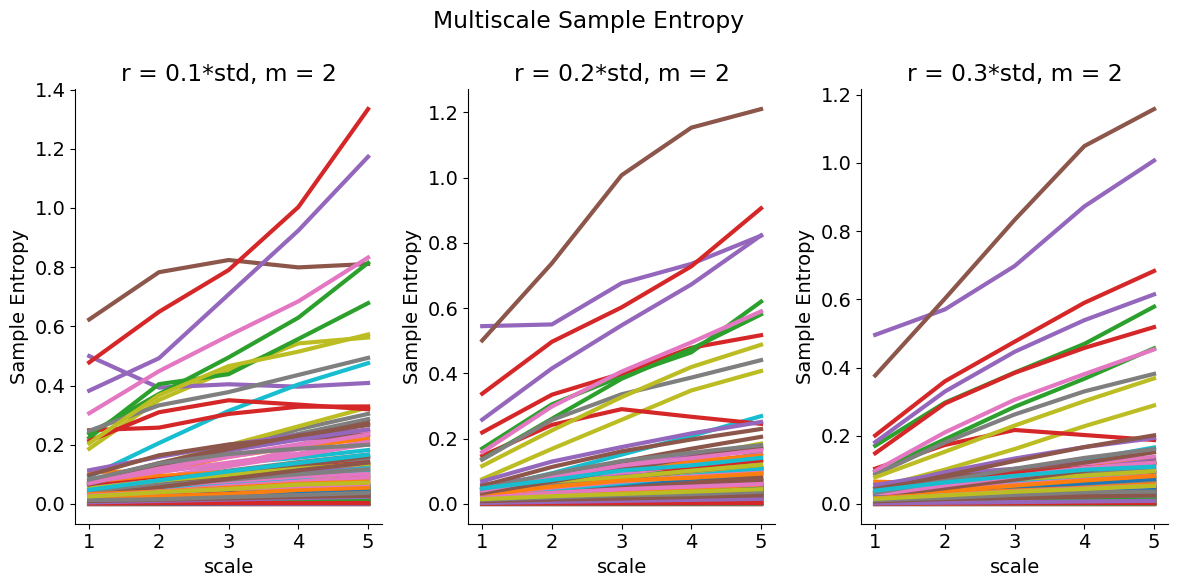

In [564]:
fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = '14'
for i in range(len(multiscale_entropy_list_all_dr[0])):
    for j in range(len(multiscale_entropy_list_all_dr[0][i])):
        axes[0].plot(np.arange(1,6), multiscale_entropy_list_all_dr[0][i][j], linewidth = 3)

axes[0].set_xticks([1,2,3,4,5])
axes[0].set_xlabel('scale')
axes[0].set_ylabel('Sample Entropy')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('r = 0.1*std, m = 2')

for i in range(len(multiscale_entropy_list_all_dr[1])):
    for j in range(len(multiscale_entropy_list_all_dr[1][i])):
        axes[1].plot(np.arange(1,6), multiscale_entropy_list_all_dr[1][i][j], linewidth = 3)

axes[1].set_xticks([1,2,3,4,5])
axes[1].set_xlabel('scale')
axes[1].set_ylabel('Sample Entropy')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('r = 0.2*std, m = 2')

for i in range(len(multiscale_entropy_list_all_dr[2])):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        axes[2].plot(np.arange(1,6), multiscale_entropy_list_all_dr[2][i][j], linewidth = 3)

axes[2].set_xticks([1,2,3,4,5])
axes[2].set_xlabel('scale')
axes[2].set_ylabel('Sample Entropy')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_title('r = 0.3*std, m = 2')
plt.suptitle('Multiscale Sample Entropy')
plt.tight_layout()

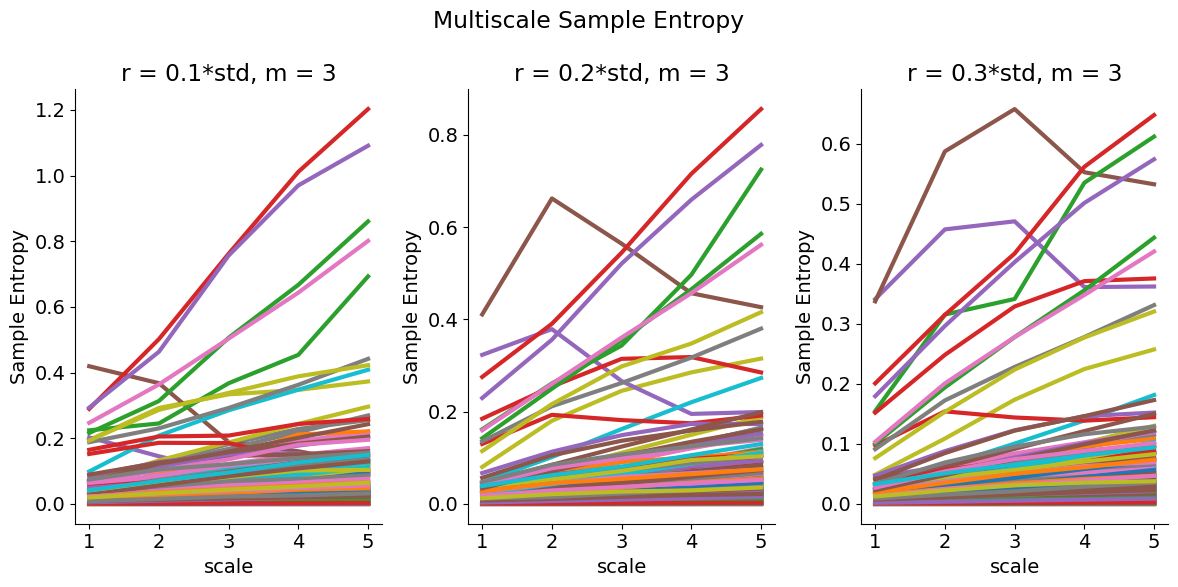

In [316]:
fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = '14'
for i in range(len(multiscale_entropy_list_all_dr_dx3[0])):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[0][i])):
        axes[0].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[0][i][j], linewidth = 3)

axes[0].set_xticks([1,2,3,4,5])
axes[0].set_xlabel('scale')
axes[0].set_ylabel('Sample Entropy')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('r = 0.1*std, m = 3')

for i in range(len(multiscale_entropy_list_all_dr_dx3[1])):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[1][i])):
        axes[1].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[1][i][j], linewidth = 3)

axes[1].set_xticks([1,2,3,4,5])
axes[1].set_xlabel('scale')
axes[1].set_ylabel('Sample Entropy')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('r = 0.2*std, m = 3')

for i in range(len(multiscale_entropy_list_all_dr_dx3[2])):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[2][i])):
        axes[2].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[2][i][j], linewidth = 3)

axes[2].set_xticks([1,2,3,4,5])
axes[2].set_xlabel('scale')
axes[2].set_ylabel('Sample Entropy')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_title('r = 0.3*std, m = 3')
plt.suptitle('Multiscale Sample Entropy')
plt.tight_layout()

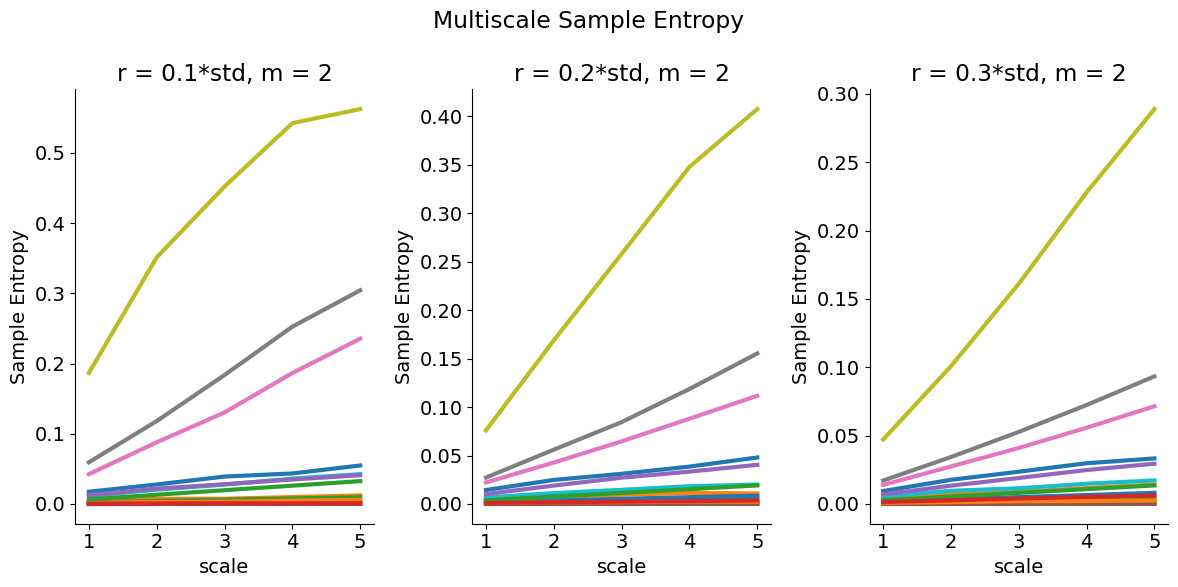

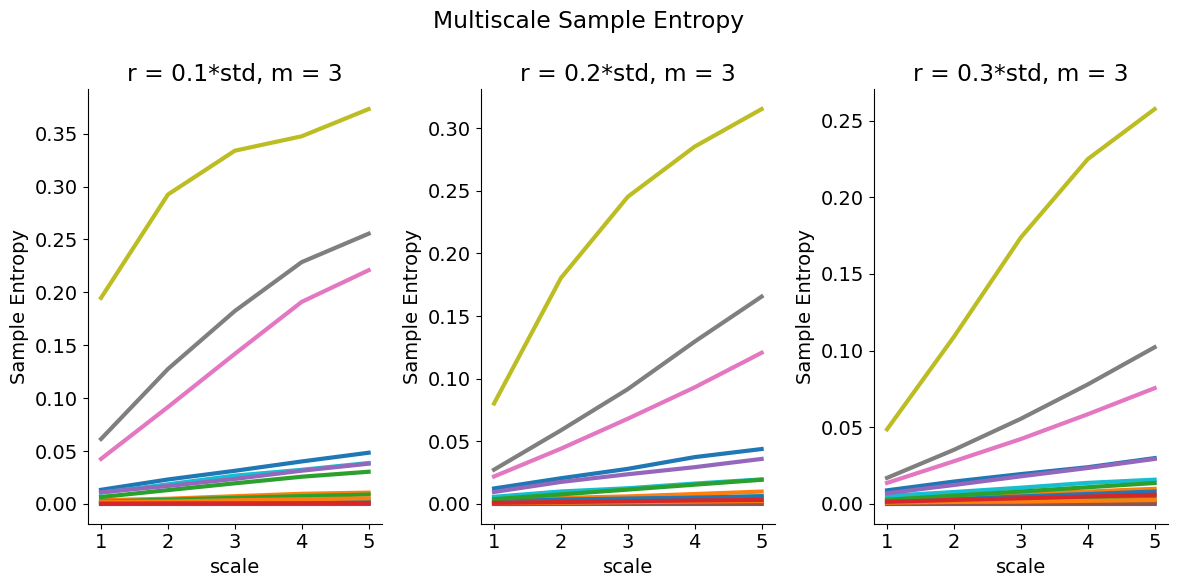

In [318]:
fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = '14'
for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr[0][i])):
        axes[0].plot(np.arange(1,6), multiscale_entropy_list_all_dr[0][i][j], linewidth = 3)

axes[0].set_xticks([1,2,3,4,5])
axes[0].set_xlabel('scale')
axes[0].set_ylabel('Sample Entropy')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('r = 0.1*std, m = 2')

for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr[1][i])):
        axes[1].plot(np.arange(1,6), multiscale_entropy_list_all_dr[1][i][j], linewidth = 3)

axes[1].set_xticks([1,2,3,4,5])
axes[1].set_xlabel('scale')
axes[1].set_ylabel('Sample Entropy')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('r = 0.2*std, m = 2')

for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        axes[2].plot(np.arange(1,6), multiscale_entropy_list_all_dr[2][i][j], linewidth = 3)

axes[2].set_xticks([1,2,3,4,5])
axes[2].set_xlabel('scale')
axes[2].set_ylabel('Sample Entropy')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_title('r = 0.3*std, m = 2')
plt.suptitle('Multiscale Sample Entropy')
plt.tight_layout()
plt.savefig('MSEm=2.svg')

fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = '14'
for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[0][i])):
        axes[0].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[0][i][j], linewidth = 3)

axes[0].set_xticks([1,2,3,4,5])
axes[0].set_xlabel('scale')
axes[0].set_ylabel('Sample Entropy')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('r = 0.1*std, m = 3')

for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[1][i])):
        axes[1].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[1][i][j], linewidth = 3)

axes[1].set_xticks([1,2,3,4,5])
axes[1].set_xlabel('scale')
axes[1].set_ylabel('Sample Entropy')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('r = 0.2*std, m = 3')

for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr_dx3[2][i])):
        axes[2].plot(np.arange(1,6), multiscale_entropy_list_all_dr_dx3[2][i][j], linewidth = 3)

axes[2].set_xticks([1,2,3,4,5])
axes[2].set_xlabel('scale')
axes[2].set_ylabel('Sample Entropy')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_title('r = 0.3*std, m = 3')
plt.suptitle('Multiscale Sample Entropy')
plt.tight_layout()
plt.savefig('MSEm=3.svg')

Text(0.5, 1.0, 'Multiscale Sample Entropy (r = 0.3*std)')

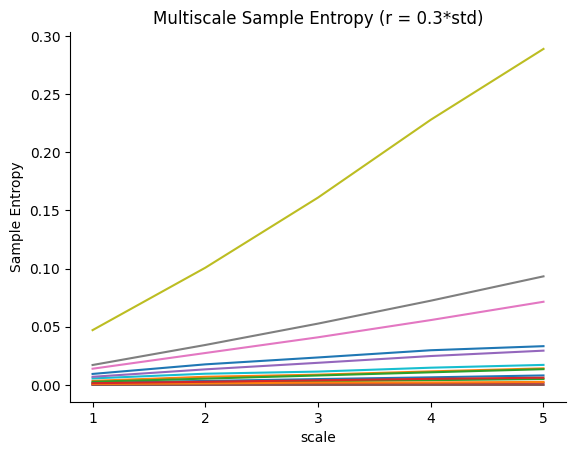

In [300]:
fig, ax = plt.subplots()
for i in range(5):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        ax.plot(np.arange(1,6), multiscale_entropy_list_all_dr[2][i][j])

ax.set_xticks([1,2,3,4,5])
ax.set_xlabel('scale')
ax.set_ylabel('Sample Entropy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Multiscale Sample Entropy (r = 0.3*std)')

# Random correlation of slope of increase

(array([187.,  47.,   4.,   2.,   4.,   2.,   2.,   0.,   0.,   1.]),
 array([-0.01054761,  0.0105983 ,  0.03174421,  0.05289012,  0.07403603,
         0.09518194,  0.11632784,  0.13747375,  0.15861966,  0.17976557,
         0.20091148]),
 <BarContainer object of 10 artists>)

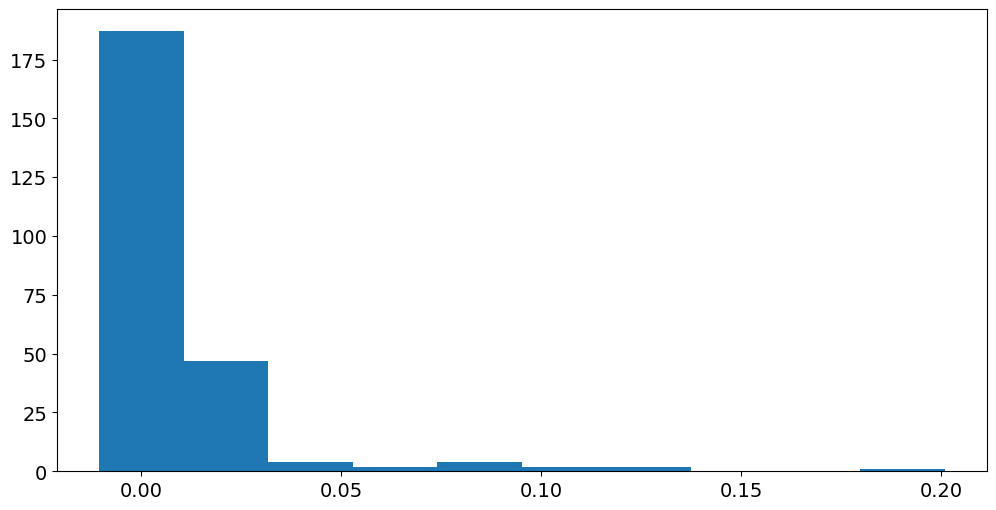

In [468]:
slope_list = []
for i in range(len(multiscale_entropy_list_all_dr[2])):
    for j in range(len(multiscale_entropy_list_all_dr[2][i])):
        slope_list.append(np.polyfit(np.arange(1,6),multiscale_entropy_list_all_dr[2][i][j],deg=1)[0])
plt.hist(slope_list)

# Cross Entropy

In [ ]:
heat_map = np.zeros((3,3))
for i in tqdm(range(len(rating_all))):
    for j in range(len(rating_all)):
        rating_0_trial = rating_all[i][0].reshape(len(rating_all[i][0]),1)
        rating_1_trial = rating_all[i][0].reshape(len(rating_all[i][0]),1)
        if len(rating_0_trial) > len(rating_1_trial):
            rating_0_trial = rating_0_trial[:len(rating_1_trial)]
        if len(rating_0_trial) < len(rating_1_trial):
            rating_1_trial = rating_1_trial[:rating_0_trial]
        rating_0_part_trial = np.hstack([rating_0_trial,rating_1_trial])
        heat_map[i,j] = EH.XSampEn(rating_0_part_trial)[0][2]


In [198]:
heat_maps = []
for i in tqdm(range(5)):
    heat_map = np.zeros((len(rating_all[i]),len(rating_all[i])))
    for j in range(len(rating_all[i])):
        for k in range(len(rating_all[i])):
            rating_0_trial = rating_all[i][j].reshape(len(rating_all[i][j]),1)
            rating_1_trial = rating_all[i][k].reshape(len(rating_all[i][k]),1)
            if len(rating_0_trial) > len(rating_1_trial):
                rating_0_trial = rating_0_trial[:len(rating_1_trial)]
            if len(rating_0_trial) < len(rating_1_trial):
                rating_1_trial = rating_1_trial[:len(rating_0_trial)]
            rating_0_part_trial = np.hstack([rating_0_trial,rating_1_trial])
            heat_map[j,k] = EH.XSampEn(rating_0_part_trial)[0][2]
    heat_maps.append(heat_map)

  0%|          | 0/5 [00:00<?, ?it/s]

In [199]:
heat_maps

[array([[0.01468904, 0.01690765, 0.00704853],
        [0.01690765, 0.00456443, 0.01831009],
        [0.00704853, 0.01831009, 0.00157034]]),
 array([[0.00085428,        nan, 0.03512965],
        [       nan, 0.00046583, 0.00548821],
        [0.03512965, 0.00548821, 0.00049467]]),
 array([[0.02274605, 0.02346417, 0.04725188],
        [0.02346417, 0.02806242, 0.0404336 ],
        [0.04725188, 0.0404336 , 0.07603177]]),
 array([[0.00686566, 0.0137021 , 0.00840853],
        [0.0137021 , 0.00211285, 0.00138164],
        [0.00840853, 0.00138164, 0.00111687]]),
 array([[0.00428191, 0.01726314, 0.00530672],
        [0.01726314, 0.00142408, 0.02084892],
        [0.00530672, 0.02084892, 0.01023598]])]